In [7]:
# Standard DS imports
import pandas as pd
import numpy as np
from sklearn import neighbors
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
import ast
from sklearn import svm

# All pytorch dependencies
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split



# all tensorflow dependencies
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping
from keras import metrics

In [23]:
def analyze_algorithm(y_true, y_pred):

    # Calculate all scoring metrics
    accuracy = accuracy_score(y_true, y_pred)
    
    precision = precision_score(y_true, y_pred, average='macro')
    
    recall = recall_score(y_true, y_pred, average='macro')
    
    f1 = f1_score(y_true, y_pred)

    precision_auc, recall_auc, _ = precision_recall_curve(y_true, y_pred)
    auprc = auc(recall_auc, precision_auc)
    
    cm = confusion_matrix(y_true, y_pred)



    print(f"Accuracy: {round(accuracy, 6)}")

    print(f"Recall: {round(recall, 6)}")

    print(f"Precision: {round(precision, 6)}")

    print(f"F1 Score: {round(f1, 6)}")

    print(f"AUPRC: {round(auprc, 6)}")

    # Visualize the confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    



def print_correlation_matrix(dataframe):
    # Calculate correlation matrix
    corr_matrix = dataframe.corr()
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True,)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.show()

tracks.csv read in successfully as a dataframe


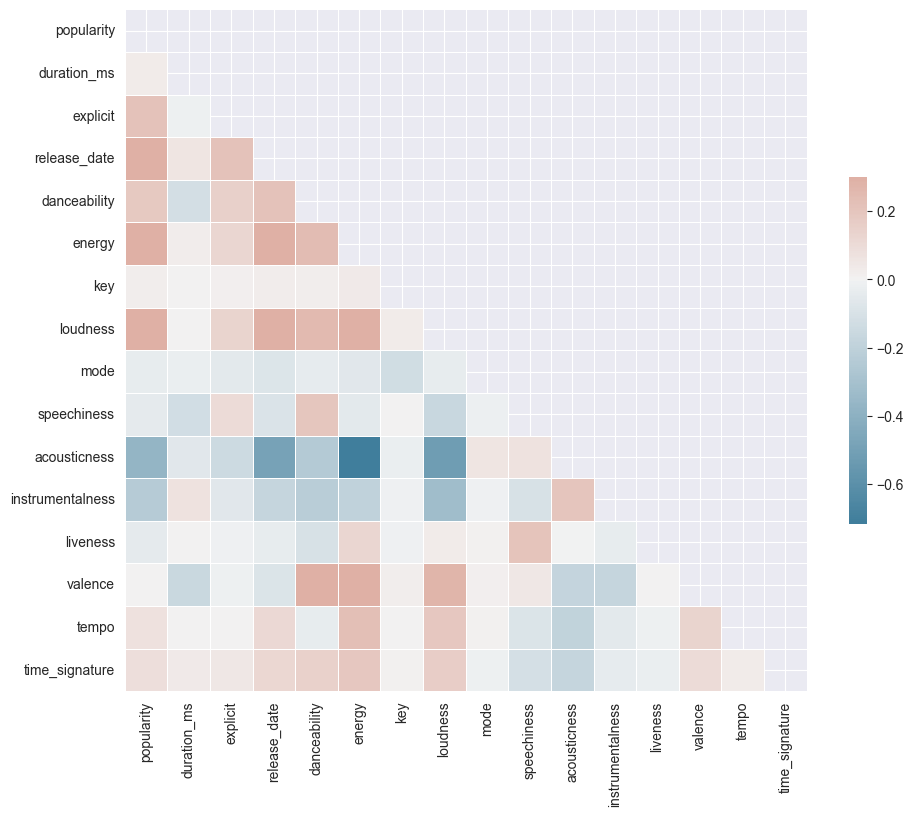

KNN-Regressor Fitted

scores for the training set:
Accuracy: 0.926511
Recall: 0.52213
Precision: 0.898162
F1 Score: 0.961718
AUPRC: 0.963347


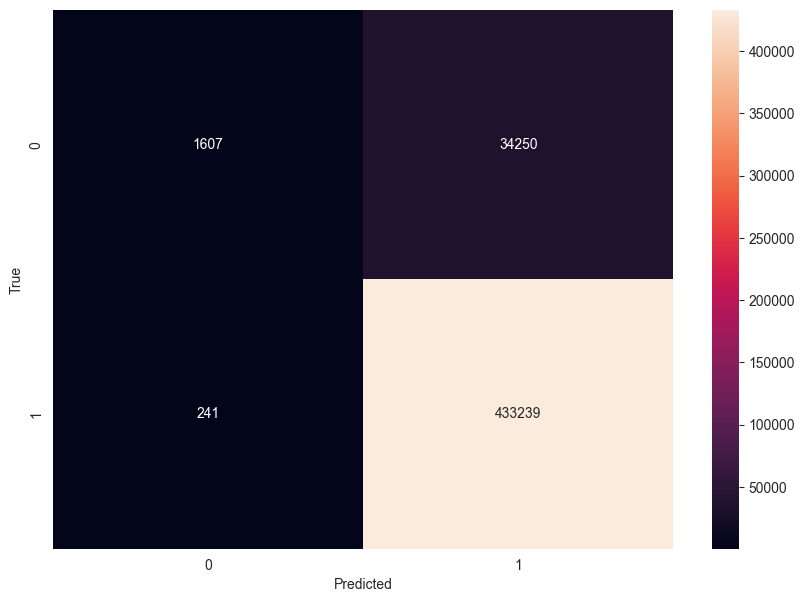


scores for the testing set:
Accuracy: 0.924728
Recall: 0.5103
Precision: 0.713712
F1 Score: 0.960824
AUPRC: 0.963011


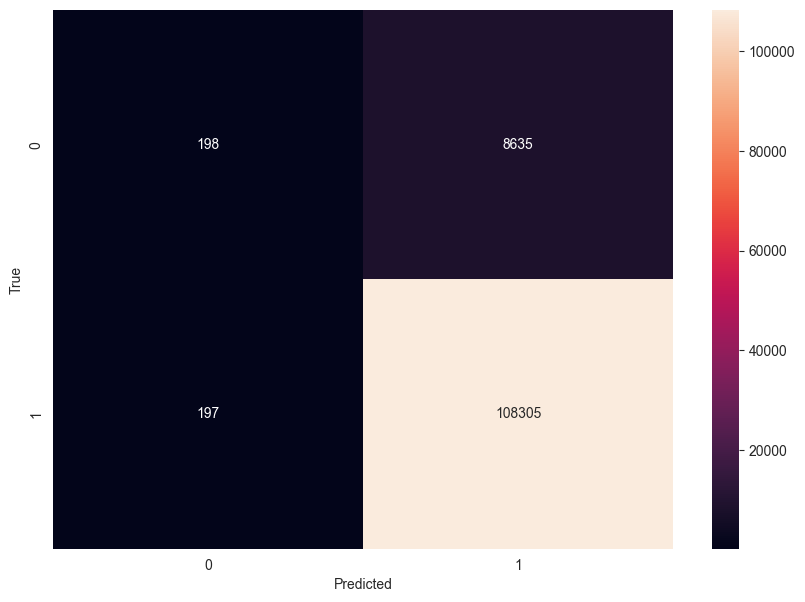

dataset.csv read in successfully as a dataframe


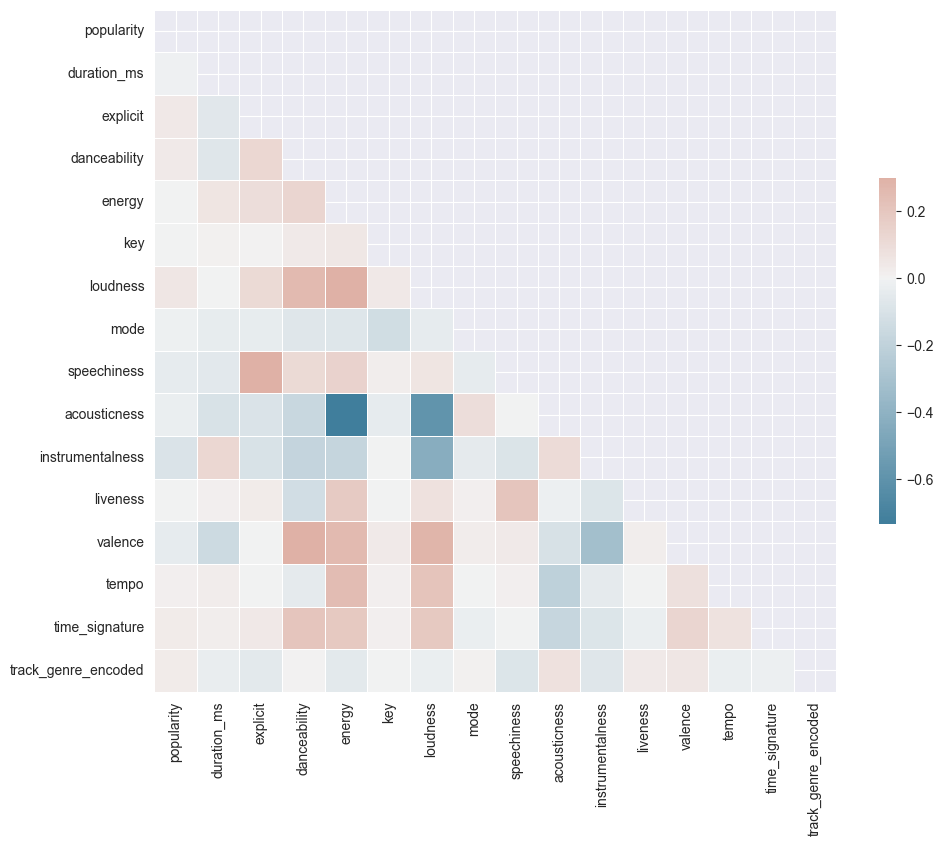

KNN-Regressor Fitted

scores for the training set:
Accuracy: 0.899112
Recall: 0.66055
Precision: 0.887348
F1 Score: 0.944161
AUPRC: 0.949708


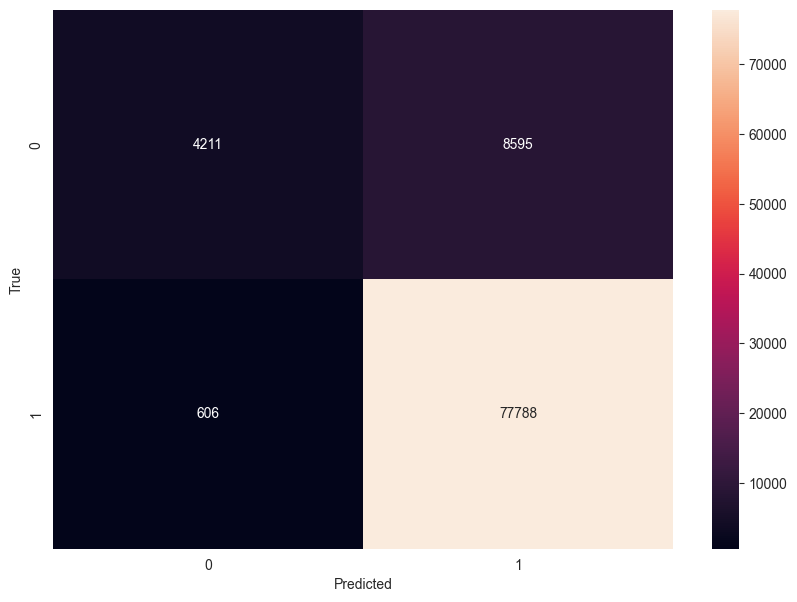


scores for the testing set:
Accuracy: 0.881228
Recall: 0.619031
Precision: 0.807025
F1 Score: 0.934367
AUPRC: 0.943565


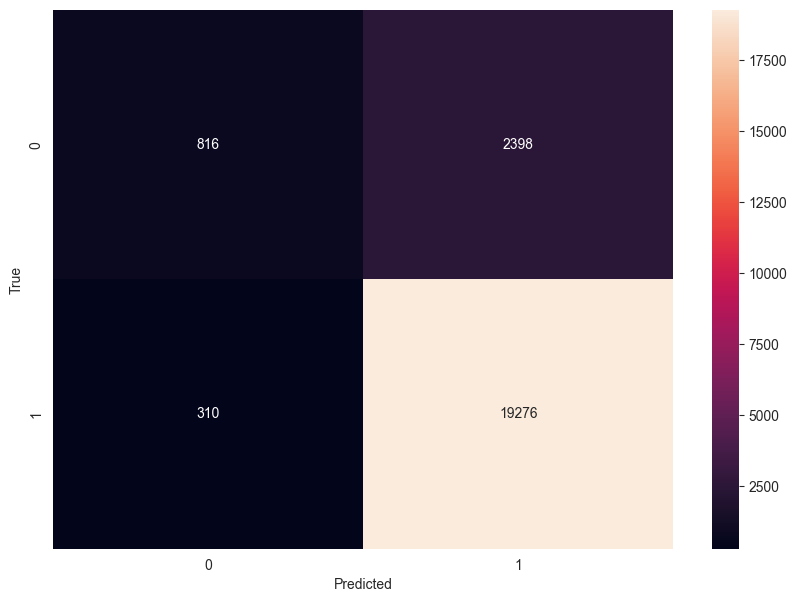

In [24]:
# Putting file specific info into arrays for easier access
files = ['tracks.csv', 'dataset.csv']
inputs = [
            [ 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit'],
                  
            ['track_genre_encoded', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit']
        ]
target = ['popularity']

# Global var for selecting popularity cutoff
Cutoff = 70
Cutoffp = Cutoff / 100


for i in range(len(files)):

    df = pd.read_csv('./'+files[i])
    print(files[i], 'read in successfully as a dataframe')
    # File specific cleaning
    
    # Data cleaning for tracks.csv
    if i == 0:
        df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year
        df = df.drop(columns=['id', 'name', 'artists', 'id_artists'])
        
    # Data cleaning for dataset.csv
    if i == 1:
        df['track_genre_encoded'] = LabelEncoder().fit_transform(df['track_genre'])
        df = df.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre'])
        
       
    print_correlation_matrix(df)

    xtrain, xtest, ytrain, ytest = train_test_split(df[inputs[i]], df[target], test_size=0.2, random_state=42)
    
    # Training Model 1 KNN-Regressor
    model = neighbors.KNeighborsRegressor(4)
    model.fit(xtrain, ytrain)
    
    print('KNN-Regressor Fitted')
    # creating predictions
    y_train_scores = model.predict(xtrain)
    y_test_scores = model.predict(xtest)
    
    # Apply same threshold to train predictions
    y_train_pred = (y_train_scores > Cutoffp).astype(int)
    y_test_pred = (y_test_scores > Cutoffp).astype(int)
    
    ytrain = (ytrain > Cutoffp).astype(int)
    ytest = (ytest > Cutoffp).astype(int)
    
    print('\nscores for the training set:')
    analyze_algorithm(ytrain, y_train_pred)
    
    print('\nscores for the testing set:')
    analyze_algorithm(ytest, y_test_pred)
    